In [34]:
import h5py

In [35]:
data_bg = h5py.File('../data/SimpleQCD.h5', 'r')
data_sig = h5py.File('../data/SimpleVBF.h5', 'r')

In [36]:
import numpy as np
from numpy.lib import recfunctions as rfn

def create_data(events, n_particles, is_background):
    result = events[:, :n_particles]
    result = rfn.structured_to_unstructured(result)

    if is_background:
        labels = np.zeros(result.shape[0], dtype=np.float32)
    else:
        labels = np.ones(result.shape[0], dtype=np.float32)

    return result, labels



In [37]:
input_bg, labels_bg = create_data(data_bg["INPUTS"]["PARTICLES"],5, is_background=True)
input_sig, labels_sig = create_data(data_sig["INPUTS"]["PARTICLES"],5, is_background=False)
input_data = np.concatenate((input_bg, input_sig), axis=0)
labels = np.concatenate((labels_bg, labels_sig), axis=0)

In [38]:
import torch
device = "mps" if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
input_data.shape

Using mps device


(148031, 5, 7)

In [39]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class LogScaler(BaseEstimator, TransformerMixin):
    def __init__(self, offset=1e-3, add_mask = False):
        self.offset = offset
        self.add_mask = add_mask

    def fit(self, X, y=None):
        return self  # no fitting needed

    def transform(self, X):
        log = np.log(X + self.offset)
        # Create a mask for nan values
        mask = np.isnan(log)
        if self.add_mask:
            return np.hstack([mask, log])
        return log

class PhiTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sin_phi = np.sin(X)
        cos_phi = np.cos(X)
        return np.hstack([sin_phi, cos_phi])


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler


energy_indices = [0]
eta_indices = [1]
phi_indices = [2]
pt_indices = [3]
btag_indices = [4]
scaler = ColumnTransformer(
    [('E', LogScaler(add_mask=False), energy_indices),
    ('phi', PhiTransformer(), phi_indices),
    ('eta',StandardScaler(), eta_indices),
    ('pt',LogScaler(), pt_indices),
    ('btag', MinMaxScaler(), btag_indices)
    ],
    remainder='passthrough'
)

print("Before transformation:", input_data[:100].reshape(-1, 7)[0])
test_data_transformed = scaler.fit_transform(input_data[:100].reshape(-1, 7))
print("After transformation:", test_data_transformed[0])
input_data.shape

Before transformation: [967.831      -4.109512   -0.9858682  31.766512   -1.          0.
   1.       ]
After transformation: [ 6.8750587  -0.8337518   0.5521394  -2.6360438   3.458444    0.75000006
  0.          1.        ]


(148031, 5, 7)

In [40]:
input_data_transformed = scaler.fit_transform(input_data.reshape((-1,7)))
input_data_transformed = input_data_transformed.reshape((input_data.shape[0],input_data.shape[1],8))
X_train = input_data_transformed
print(X_train.shape)
print(labels.shape)

# Find nans or infs in the data, show the indices
if np.isnan(input_data).any():
    nan_indices = np.argwhere(np.isnan(input_data))
    # print("NaN indices:", nan_indices)
# Remove repeated indices from nan_indices    
nan_indices = np.unique(nan_indices[:,0])
# Remove this datapoints from X_train
X_train = np.delete(X_train, nan_indices, axis=0)
labels = np.delete(labels, nan_indices, axis=0)


(148031, 5, 8)
(148031,)


In [41]:
# As tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(labels, dtype=torch.float32)


In [42]:
from torch.utils.data import TensorDataset, DataLoader

# dataset = TensorDataset(sub_inputs, sub_target)
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=2*512, shuffle=True, drop_last=True, num_workers=10, persistent_workers=True)

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class BasicTransformer(nn.Module):
    def __init__(self, input_dim, nhead, num_layers):
        super(BasicTransformer, self).__init__()
        # Input embedding head
        self.input_embedder = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(input_dim, 64),
        )
        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=64, nhead=2,batch_first=True),
            num_layers=num_layers, enable_nested_tensor=False)


        self.output_classifier_head = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def mean_pooling(self,x):
        """
        Mean pooling implementation
        """
        # x: (batch_size, num_tokens, embed_dim)
        return x.mean(dim=1)

    def attention_pooling(self,x):

        """
        Attention pooling implementation
        """
        # x: (batch_size, num_tokens, embed_dim)
        B = x.size(0)
        pool_query = nn.Parameter(torch.randn(1, 1, 32)).to(device)
        query = pool_query.expand(B, -1, -1)  # (B, 1, embed_dim)

        # Compute attention scores
        attn_scores = torch.matmul(query, x.transpose(1, 2))  # (B, 1, num_tokens)
        attn_weights = torch.softmax(attn_scores, dim=-1)     # (B, 1, num_tokens)

        # Weighted sum
        pooled = torch.matmul(attn_weights, x)  # (B, 1, embed_dim)
        return pooled.squeeze(1)

    def forward(self, x):
        x = self.input_embedder(x)
        x = self.transformer_encoder(x)
        # x = self.attention_pooling(x)
        x = self.mean_pooling(x)
        x = self.output_classifier_head(x)
        return F.sigmoid(x)

In [44]:
model = BasicTransformer(input_dim=8, nhead=10, num_layers=5)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.0001)
criterion = nn.BCELoss(reduction='mean')

In [45]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {num_params:,}")
param_size_MB = num_params * 4 / 1024  # Approximate size in MB (assuming 4 bytes per parameter)
print(f"Approx model size: {param_size_MB:.2f} MB")

Total parameters: 1,408,521
Approx model size: 5502.04 MB


In [46]:
# Training loop with losses stored  in a list
train_losses = []
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        inputs_device = inputs.to(device)
        targets_device = targets.to(device)
        outputs = model(inputs_device)
        loss = criterion(outputs.squeeze(), targets_device)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/100, Loss: 0.6744
Epoch 2/100, Loss: 0.4754
Epoch 3/100, Loss: 0.4231
Epoch 4/100, Loss: 0.4156
Epoch 5/100, Loss: 0.4073
Epoch 6/100, Loss: 0.3988
Epoch 7/100, Loss: 0.3961
Epoch 8/100, Loss: 0.3953
Epoch 9/100, Loss: 0.3941
Epoch 10/100, Loss: 0.3904
Epoch 11/100, Loss: 0.3925
Epoch 12/100, Loss: 0.3909
Epoch 13/100, Loss: 0.3900
Epoch 14/100, Loss: 0.3890
Epoch 15/100, Loss: 0.3873
Epoch 16/100, Loss: 0.3868
Epoch 17/100, Loss: 0.3859
Epoch 18/100, Loss: 0.3850
Epoch 19/100, Loss: 0.3820
Epoch 20/100, Loss: 0.3824
Epoch 21/100, Loss: 0.3818
Epoch 22/100, Loss: 0.3799
Epoch 23/100, Loss: 0.3787
Epoch 24/100, Loss: 0.3790
Epoch 25/100, Loss: 0.3771
Epoch 26/100, Loss: 0.3781
Epoch 27/100, Loss: 0.3776
Epoch 28/100, Loss: 0.3766
Epoch 29/100, Loss: 0.3759
Epoch 30/100, Loss: 0.3769
Epoch 31/100, Loss: 0.3765
Epoch 32/100, Loss: 0.3759
Epoch 33/100, Loss: 0.3764
Epoch 34/100, Loss: 0.3763
Epoch 35/100, Loss: 0.3742
Epoch 36/100, Loss: 0.3733
Epoch 37/100, Loss: 0.3751
Epoch 38/1

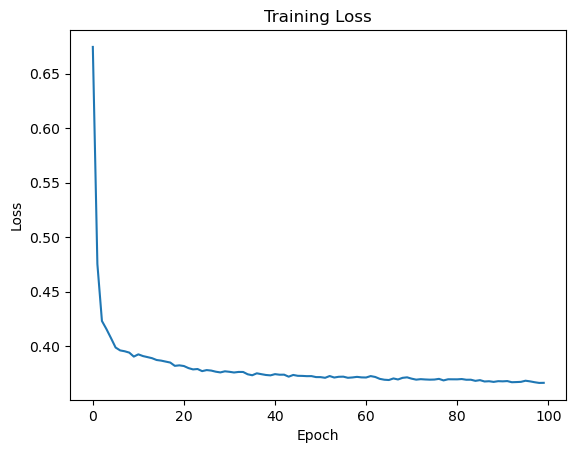

In [47]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

(0.0, 1.0)

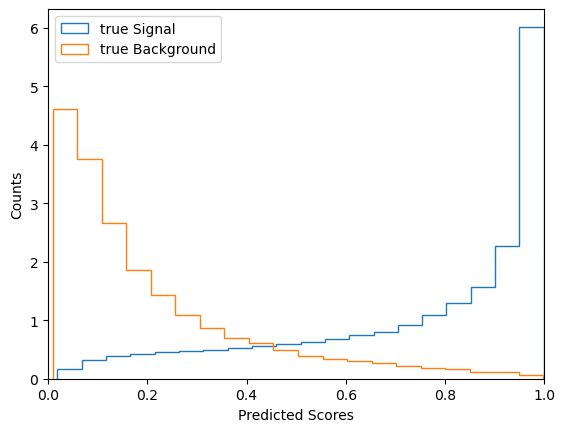

In [48]:
model.to('cpu')
model.eval()
X_train_tensor = X_train_tensor.cpu()
y_train_tensor = y_train_tensor.cpu()
y_pred = model(X_train_tensor).detach()
true_signal = y_pred[y_train_tensor==1].numpy()
true_bkg = y_pred[y_train_tensor==0].numpy()

import matplotlib.pyplot as plt
plt.hist(true_signal, bins=20, histtype='step', label='Signal', density=True)
plt.hist(true_bkg, bins=20, histtype='step', label='Background', density=True)
plt.legend(["true Signal","true Background"])
plt.xlabel("Predicted Scores")
plt.ylabel("Counts")
plt.xlim((0.0,1.0))

In [49]:
# sklearn.metrics require exact value matches, so we need to round to 0 or 1
final_prediction_score =y_pred.numpy()
final_prediction = np.round(final_prediction_score)
# Compute the accuracy_score
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_train_tensor, final_prediction)
print(accuracy)

0.8319708680142688


In [50]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_tensor,final_prediction_score)

np.float64(0.9205364172684607)